In [5]:
import numpy as np
import scipy as sp
import os
import itertools
import time
import multiprocessing as mp
from pathlib import Path

import torch
from torch.utils.data import DataLoader

from qtorch.quant import Quantizer, quantizer
from qtorch.optim import OptimLP
from torch.optim import SGD
from qtorch import FloatingPoint
from qtorch.auto_low import sequential_lower

import math
from scipy.stats import norm # for GP
from scipy.stats import sem # standard error

from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()

import itertools
import sys
sys.path.append('..')
import train_func as tf

import mkl
mkl.set_num_threads(1)

import apgpy
from sklearn.utils.extmath import randomized_svd
from scipy.sparse.linalg import svds

from experiment_design import pivot_columns, greedy_stepwise_selection
from scipy.stats import sem
from matplotlib import pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'weight': 'bold'})
rc('text', usetex=True)

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

In [6]:
def relative_error(mtx_true, mtx_pred):
    return np.linalg.norm(mtx_true - mtx_pred) / np.linalg.norm(mtx_true)

In [7]:
# Metric 1: convergence

def get_closest_dist(true_all, pred):
    """
    true_all: a (n_points, dim_points) array. 
    pred: the single point to compute distance from.
    """
    dist_all = []
    for ref in true_all:
        dist_all.append(np.linalg.norm(pred - ref))
    return np.min(dist_all)    

def get_convergence_metric(error_true_at_true_frontier, memory_true_at_true_frontier, 
                          error_pred_at_pred_frontier, memory_true_at_pred_frontier,
                          range_error_true, range_error_pred, range_memory):
    error_true_at_true_frontier_rescaled = error_true_at_true_frontier / range_error_true
    error_pred_at_pred_frontier_rescaled = error_pred_at_pred_frontier / range_error_pred
    memory_true_at_true_frontier_rescaled = memory_true_at_true_frontier / range_memory
    memory_true_at_pred_frontier_rescaled = memory_true_at_pred_frontier / range_memory
    
    costs_at_true_frontier = np.hstack((error_true_at_true_frontier_rescaled.reshape(-1, 1), 
                                        memory_true_at_true_frontier_rescaled.reshape(-1, 1)))
    costs_at_pred_frontier = np.hstack((error_pred_at_pred_frontier_rescaled.reshape(-1, 1), 
                                        memory_true_at_pred_frontier_rescaled.reshape(-1, 1)))
    
#     dists = np.full(len(error_pred_at_pred_frontier), np.nan)
    dists = []
    for cost_pred in costs_at_pred_frontier:
        dists.append(get_closest_dist(costs_at_true_frontier, cost_pred))
#     return dists
    return np.average(dists)


# Metric 2: hypervolume difference

def hypervolume(x_all, y_all, x_max, y_max):
    x_all = np.array(x_all)
    y_all = np.array(y_all)
    
    assert all(x_all <= x_max), "there are x values larger than x_max"
    assert all(y_all <= y_max), "there are y values larger than y_max"
    assert len(x_all) == len(y_all)
#     assert all((np.diff(x_all) > 0) != (np.diff(y_all) > 0)) # XOR
    x_all_sorted = np.sort(x_all)
    y_all_rev_sorted = -np.sort(-y_all)
    y_all_rev_sorted_diff = -np.diff(y_all_rev_sorted)
    y_all_rev_sorted_diff = np.insert(y_all_rev_sorted_diff, 0, y_max-y_all_rev_sorted[0])
    return np.sum([(x_max - x_all[i]) * y_all_rev_sorted_diff[i] for i in range(len(x_all))])
    

def hypervolume_difference(error_true_at_true_frontier, memory_true_at_true_frontier, 
                error_pred_at_pred_frontier, memory_true_at_pred_frontier,
                range_error_true, range_error_pred, range_memory, 
                max_error, max_memory):
    error_true_at_true_frontier_rescaled = error_true_at_true_frontier / range_error_true
    error_pred_at_pred_frontier_rescaled = error_pred_at_pred_frontier / range_error_pred
    memory_true_at_true_frontier_rescaled = memory_true_at_true_frontier / range_memory
    memory_true_at_pred_frontier_rescaled = memory_true_at_pred_frontier / range_memory
    max_error_rescaled = max_error / range_error_true
    max_memory_rescaled = max_memory / range_memory
    
    hypervolume_true = hypervolume(memory_true_at_true_frontier_rescaled, error_true_at_true_frontier_rescaled,
                                   max_memory_rescaled, max_error_rescaled)
    
    hypervolume_pred = hypervolume(memory_true_at_pred_frontier_rescaled, error_pred_at_pred_frontier_rescaled,
                                   max_memory_rescaled, max_error_rescaled)
    
    return np.abs(hypervolume_pred - hypervolume_true)

def hypervolume_difference_no_error_scaling(error_true_at_true_frontier, memory_true_at_true_frontier, 
                error_pred_at_pred_frontier, memory_true_at_pred_frontier,
                max_error, max_memory):
    memory_true_at_true_frontier_rescaled = memory_true_at_true_frontier / max_memory
    memory_true_at_pred_frontier_rescaled = memory_true_at_pred_frontier / max_memory   
    
    hypervolume_true = hypervolume(memory_true_at_true_frontier_rescaled, error_true_at_true_frontier,
                                   1, max_error)    
    hypervolume_pred = hypervolume(memory_true_at_pred_frontier_rescaled, error_pred_at_pred_frontier,
                                   1, max_error)
    
    return np.abs(hypervolume_pred - hypervolume_true)
    

In [8]:
data_path = os.path.join(Path(os.getcwd()).parent.absolute(), 'data')

accuracy_matrix = np.load(os.path.join(data_path, 'acc_matrix_res64_all.npy'))
memory_matrix = np.load(os.path.join(data_path, 'mem_matrix_full.npy'))
error_matrix = 1 - accuracy_matrix

idx_dataset_to_remove = 28 # remove full CIFAR100
memory_matrix = np.delete(memory_matrix, idx_dataset_to_remove, axis=0)
error_matrix = np.delete(error_matrix, idx_dataset_to_remove, axis=0)

In [9]:
def approx_matrix_rank(a, threshold=0.03):
    """Compute approximate rank of a matrix.
    Args:
        a (np.ndarray):    Matrix for which to compute rank.
        threshold (float): All singular values less than threshold * (largest singular value) will be set to 0
    Returns:
        int: The approximate rank of a.
    """
    s = np.linalg.svd(a, compute_uv=False)
    rank = s[s >= threshold * s[0]]
    return len(rank)

In [10]:
def pca(a, rank=None, threshold=None):
    """Solves: minimize ||A_XY||^2 where ||.|| is the Frobenius norm.
    Args:
        a (np.ndarray):    Matrix for which to compute PCA.
        threshold (float): Threshold specifying approximate rank of a.
        rank (int):        The approximate rank.
    Returns:
        x, y (np.ndarray): The solutions to the PCA problem.
        vt (np.ndarray):   Transpose of V as specified in the singular value decomposition.
    """
    assert (threshold is None) != (rank is None), "Exactly one of threshold and rank should be specified."
    if threshold is not None:
        rank = approx_matrix_rank(a, threshold)
    # std = np.std(a, axis=0)
    u, s, vt = svds(a, k=rank)

    nonzero_pos = np.where(s > 0)[0]
    s = s[nonzero_pos]
    u = u[:, nonzero_pos]
    vt = vt[nonzero_pos, :]

    u = np.fliplr(u)
    s = np.flipud(s)
    vt = np.flipud(vt)

    sigma = np.diag(s)
    x = np.dot(u, sigma).T
    y = vt
    return x, y, vt

In [11]:
# low precision configurations
low_formats = [['Representation_Float', '5', 1],['Representation_Float', '6', 2],
               ['Representation_Float', '7', 3],['Representation_Float', '8', 4],
               ['Representation_Float', '6', 1],['Representation_Float', '7', 2],
               ['Representation_Float', '8', 3],['Representation_Float', '9', 4],
               ['Representation_Float', '7', 1],['Representation_Float', '8', 2],
               ['Representation_Float', '9', 3]]

high_formats = [['Representation_Float', '14', 7],['Representation_Float', '16', 9],
                ['Representation_Float', '18', 11],['Representation_Float', '15', 7],
                ['Representation_Float', '17', 9],['Representation_Float', '19', 11],
                ['Representation_Float', '16', 7],['Representation_Float', '18', 9],
                ['Representation_Float', '20', 11]]

lp_configs = list(itertools.product(low_formats, high_formats))

In [12]:
# Very slow for many datapoints.  Fastest for many costs, most readable
def is_pareto_efficient_dumb(costs):
    """
    Find the pareto-efficient points
    :param costs: An (n_points, n_costs) array
    :return: A (n_points, ) boolean array, indicating whether each point is Pareto efficient
    """
    is_efficient = np.ones(costs.shape[0], dtype = bool)
    for i, c in enumerate(costs):
        is_efficient[i] = np.all(np.any(costs[:i]>c, axis=1)) and np.all(np.any(costs[i+1:]>c, axis=1))
    return is_efficient

def uniform_sampling(ratio, matrix, seed=0):
    sampled_matrix = matrix.copy()
    np.random.seed(seed)
    mask = np.random.choice([True, False], matrix.shape, p=[ratio, 1-ratio])
    sampled_matrix[np.invert(mask)] = np.nan
    return sampled_matrix, mask.astype(int)

def weighted_softimpute(X, M, W, lmbda, max_rank=None,
                        min_value=None, max_value=None,
                        apg_max_iter=2500, apg_eps=1e-6,
                        apg_use_restart=True):
    m = X.shape[0]
    n = X.shape[1]

    def prox(Z, t):
        Z = Z.reshape(m, n)

        # singular value shrinkage
        if max_rank is None:
            U, S, VT = svds(Z, k=min(Z.shape)-1)
            U = np.fliplr(U)
            S = np.flipud(S)
            VT = np.flipud(VT)

        else:
            U, S, VT = randomized_svd(Z, max_rank)
        S = np.maximum(S - lmbda*t, 0)
        Z = np.dot(U * S, VT)

        # clip values
        if min_value is not None:
            mask = Z < min_value
            if mask.sum() > 0:
                Z[mask] = min_value
        if max_value is not None:
            mask = Z > max_value
            if mask.sum() > 0:
                Z[mask] = max_value

        return Z.flatten()

    M_one_mask = (M == 1)
    masked_weights = W[M_one_mask]
    masked_X = X[M_one_mask]
    def grad(Z):
        grad = np.zeros((m, n))
        grad[M_one_mask] = (Z.reshape(m, n)[M_one_mask] - masked_X) * masked_weights
        return grad.flatten()

    X_hat = apgpy.solve(grad, prox, np.zeros(m*n),
                        max_iters=apg_max_iter,
                        eps=apg_eps,
                        use_gra=True,
                        use_restart=apg_use_restart,
                        quiet=True).reshape((m, n))
    return X_hat

def NormalizeData(data, min_value=0, max_value=1):
    pos = (data - np.min(data)) / (np.max(data) - np.min(data))    
    return min_value + pos * (max_value - min_value)

def nonuniform_sampling(sampling_prob, matrix, seed=0):
    sampled_matrix = matrix.copy()
    np.random.seed(seed)
    mask = (np.random.uniform(0, 1, sampling_prob.shape) < sampling_prob)
    sampled_matrix[np.invert(mask)] = np.nan
    return sampled_matrix, mask.astype(int)

# experiment design

LOOCV across datasets

In [9]:
memory_matrix_part = memory_matrix
error_matrix_part = error_matrix

memory_matrix_part_flattened = memory_matrix_part.flatten()
error_matrix_part_flattened = error_matrix_part.flatten()

In [10]:
n_greedy_all = range(5, 16)

In [11]:
def run_ED(meta_training_idx, meta_test_idx):
    meta_test_idx = meta_test_idx[0]
#     print(meta_test_idx)
    error_matrix_part_train = error_matrix_part[meta_training_idx]
    error_matrix_part_test = error_matrix_part[meta_test_idx]
    memory_matrix_part_train = memory_matrix_part[meta_training_idx]
    memory_matrix_part_test = memory_matrix_part[meta_test_idx]

    memory_matrix_part_train_flattened = memory_matrix_part_train.flatten()
    error_matrix_part_train_flattened = error_matrix_part_train.flatten()
    memory_matrix_part_test_flattened = memory_matrix_part_test.flatten()
    error_matrix_part_test_flattened = error_matrix_part_test.flatten()
    
    best_error_on_frontier_ed = [1]
    
    memory_cap = np.inf
#     memory_cap = np.median(memory_matrix_part.flatten())
#     sampling_scheme = 'no_sampling'
    sampling_scheme = 'unif'
#     sampling_scheme = 'non_unif'

    is_valid_test = np.where(memory_matrix_part_test <= memory_cap)[0]
#     print("number of valid models: {}".format(len(is_valid_test)))
    
    error_matrix_part_test_trunc = error_matrix_part_test[is_valid_test]
    memory_matrix_part_test_trunc = memory_matrix_part_test[is_valid_test]
    
    if sampling_scheme == 'unif':
        # Case 1: sample and complete the meta-training matrix
        ratio = 0.2
        error_matrix_part_train_obs_unif, M_train_unif = uniform_sampling(ratio, error_matrix_part_train, seed=0)

        W_train_unif = np.full(error_matrix_part_train_obs_unif.shape, 1.0)
        rank = 5
        error_matrix_part_train_pred_unif = weighted_softimpute(np.nan_to_num(error_matrix_part_train_obs_unif), 
                                                                M_train_unif, W_train_unif, 
                                               lmbda=.1, max_rank=rank, min_value=0, max_value=1)

        error_matrix_part_train_pred_unif_trunc = error_matrix_part_train_pred_unif[:, is_valid_test]    
        rank = 5
        U, S, Vt = np.linalg.svd(error_matrix_part_train_pred_unif_trunc)

    elif sampling_scheme == 'no_sampling':
        # Case 2: use original meta-training matrix
        error_matrix_part_train_trunc = error_matrix_part_train[:, is_valid_test]
        rank = 5
        U, S, Vt = np.linalg.svd(error_matrix_part_train_trunc)
    
    elif sampling_scheme == 'non_unif':
        max_prob = 0.2
        inverse_memory_sorted = np.sort((1/memory_matrix_part).flatten())
        inverse_memory_cdf = np.arange(len(inverse_memory_sorted)) / (len(inverse_memory_sorted) - 1)
        sampling_prob_non_unif = max_prob * inverse_memory_cdf[np.argsort(np.argsort((1/memory_matrix_part).flatten())).reshape(memory_matrix_part.shape)]
        seed = 0
        error_matrix_part_train_obs_non_unif, M_train_non_unif = nonuniform_sampling(sampling_prob_non_unif, 
                                                                 error_matrix_part, seed=seed)
        
        W_train_non_unif = 1/sampling_prob_non_unif
        error_matrix_part_train_pred_non_unif = weighted_softimpute(np.nan_to_num(error_matrix_part_train_obs_non_unif), 
                                                              M_train_non_unif, W_train_non_unif, 
                                       lmbda=.1, max_rank=5, min_value=0, max_value=1)

        error_matrix_part_train_pred_non_unif_trunc = error_matrix_part_train_pred_non_unif[:, is_valid_test]    
        rank = 5
        U, S, Vt = np.linalg.svd(error_matrix_part_train_pred_non_unif_trunc)   
        
    
    Y_ed = Vt[:rank, :]

    initialization = pivot_columns(Y_ed, rank=rank, columns_to_avoid=None)

    dist_all = []
    hd_all = []
    
    for n_greedy in n_greedy_all:
#         print(n_greedy)
        selected = greedy_stepwise_selection(Y_ed, initialization, n_greedy, columns_to_avoid=None, verbose=False)
        xt_pred_ed = np.linalg.lstsq(Y_ed[:, selected].T, error_matrix_part_test_trunc[selected], rcond=None)[0]
        error_matrix_part_test_pred_unif_trunc = xt_pred_ed @ Y_ed

        costs_test = np.hstack((memory_matrix_part_test.reshape(-1, 1), error_matrix_part_test.reshape(-1, 1)))
        is_efficient_test = is_pareto_efficient_dumb(costs_test)

        # true PF
        indices_true_test_frontier = np.where(is_efficient_test)[0]
        error_test_true_at_true_test_frontier = error_matrix_part_test[indices_true_test_frontier]
        memory_test_true_at_true_test_frontier = memory_matrix_part_test[indices_true_test_frontier]

        # predicted PF
        costs_test_pred = np.hstack((memory_matrix_part_test_trunc.reshape(-1, 1), error_matrix_part_test_pred_unif_trunc.reshape(-1, 1)))
        is_efficient_test_pred = is_pareto_efficient_dumb(costs_test_pred)
        indices_pred_test_frontier = np.where(is_efficient_test_pred)[0]
        error_test_pred_at_pred_test_frontier = error_matrix_part_test_pred_unif_trunc[indices_pred_test_frontier]
        memory_test_true_at_pred_test_frontier = memory_matrix_part_test_trunc[indices_pred_test_frontier]
        
        # get best non-dominated error under memory budget
        error_test_true_at_pred_test_frontier = error_matrix_part_test_trunc[indices_pred_test_frontier]
        indices_pred_frontier_below_cap = np.where(memory_test_true_at_pred_test_frontier <= memory_cap)[0]
        best_error_on_frontier_ed.append(min(np.min(error_matrix_part_test_trunc[selected]), 
                                             np.min(error_test_true_at_pred_test_frontier[indices_pred_frontier_below_cap])))

        max_error = max(1, np.max(error_test_pred_at_pred_test_frontier))
        max_memory = np.max(memory_matrix_part_flattened)
        
        dist = get_convergence_metric(error_test_true_at_true_test_frontier, memory_test_true_at_true_test_frontier, 
                              error_test_pred_at_pred_test_frontier, memory_test_true_at_pred_test_frontier,
                            max_error, max_error, max_memory) # do not standardize test errors for now
        dist_all.append(dist)
        
        val_hypervolume_difference = hypervolume_difference_no_error_scaling(error_test_true_at_true_test_frontier, 
                                                                             memory_test_true_at_true_test_frontier,
                                                                             error_test_pred_at_pred_test_frontier, 
                                                                             memory_test_true_at_pred_test_frontier,
                                                                             max_error, max_memory)
    
        hd_all.append(val_hypervolume_difference)      
    return dist_all, hd_all, best_error_on_frontier_ed[1:]

In [12]:
# LOOCV across datasets, fix rank, increase number of samples, see the change of PF errors

p1 = mp.Pool(100)
results = [p1.apply_async(run_ED, args=[meta_training_idx, meta_test_idx]) for meta_training_idx, meta_test_idx in loo.split(error_matrix_part)]
p1.close()
p1.join()

In [13]:
dist_all_mean_all_datasets_ed = np.full((error_matrix_part.shape[0], len(n_greedy_all)), np.nan)
hd_all_mean_all_datasets_ed = np.full((error_matrix_part.shape[0], len(n_greedy_all)), np.nan)
best_error_on_frontier_all_datasets_ed = np.full((error_matrix_part.shape[0], len(n_greedy_all)), np.nan)

for i, (meta_training_idx, meta_test_idx) in enumerate(loo.split(error_matrix_part)):        
    dist_all_mean_all_datasets_ed[meta_test_idx] = np.array(results[i].get()[0])
    hd_all_mean_all_datasets_ed[meta_test_idx] = np.array(results[i].get()[1])
    best_error_on_frontier_all_datasets_ed[meta_test_idx] = np.array(results[i].get()[2])

# random search

In [14]:
n_random_all = range(5, 16)

In [15]:
def run_random_search(meta_training_idx, meta_test_idx):
    meta_test_idx = meta_test_idx[0]
    error_matrix_part_train = error_matrix_part[meta_training_idx]
    error_matrix_part_test = error_matrix_part[meta_test_idx]
    memory_matrix_part_train = memory_matrix_part[meta_training_idx]
    memory_matrix_part_test = memory_matrix_part[meta_test_idx]

    memory_matrix_part_train_flattened = memory_matrix_part_train.flatten()
    error_matrix_part_train_flattened = error_matrix_part_train.flatten()
    memory_matrix_part_test_flattened = memory_matrix_part_test.flatten()
    error_matrix_part_test_flattened = error_matrix_part_test.flatten()
    
    best_error_on_frontier_random = [1]
    
    memory_cap = np.inf
#     memory_cap = np.median(memory_matrix_part.flatten())
#     sampling_scheme = 'no_sampling'
    sampling_scheme = 'unif'
#     sampling_scheme = 'non_unif'

    is_valid_test = np.where(memory_matrix_part_test <= memory_cap)[0]
#     print("number of valid models: {}".format(len(is_valid_test)))
    
    error_matrix_part_test_trunc = error_matrix_part_test[is_valid_test]
    memory_matrix_part_test_trunc = memory_matrix_part_test[is_valid_test]
    
    if sampling_scheme == 'unif':
        # Case 1: sample and complete the meta-training matrix
        ratio = 0.2
        error_matrix_part_train_obs_unif, M_train_unif = uniform_sampling(ratio, error_matrix_part_train, seed=0)

        W_train_unif = np.full(error_matrix_part_train_obs_unif.shape, 1.0)
        rank = 5
        error_matrix_part_train_pred_unif = weighted_softimpute(np.nan_to_num(error_matrix_part_train_obs_unif), 
                                                                M_train_unif, W_train_unif, 
                                               lmbda=.1, max_rank=rank, min_value=0, max_value=1)

        error_matrix_part_train_pred_unif_trunc = error_matrix_part_train_pred_unif[:, is_valid_test]    
        rank = 5
        U, S, Vt = np.linalg.svd(error_matrix_part_train_pred_unif_trunc)

    elif sampling_scheme == 'no_sampling':
        # Case 2: use original meta-training matrix
        error_matrix_part_train_trunc = error_matrix_part_train[:, is_valid_test]
        rank = 5
        U, S, Vt = np.linalg.svd(error_matrix_part_train_trunc)
    
    elif sampling_scheme == 'non_unif':
        max_prob = 0.2
        inverse_memory_sorted = np.sort((1/memory_matrix_part).flatten())
        inverse_memory_cdf = np.arange(len(inverse_memory_sorted)) / (len(inverse_memory_sorted) - 1)
        sampling_prob_non_unif = max_prob * inverse_memory_cdf[np.argsort(np.argsort((1/memory_matrix_part).flatten())).reshape(memory_matrix_part.shape)]
        seed = 0
        error_matrix_part_train_obs_non_unif, M_train_non_unif = nonuniform_sampling(sampling_prob_non_unif, 
                                                                 error_matrix_part, seed=seed)
        
        W_train_non_unif = 1/sampling_prob_non_unif
        error_matrix_part_train_pred_non_unif = weighted_softimpute(np.nan_to_num(error_matrix_part_train_obs_non_unif), 
                                                              M_train_non_unif, W_train_non_unif, 
                                       lmbda=.1, max_rank=5, min_value=0, max_value=1)

        error_matrix_part_train_pred_non_unif_trunc = error_matrix_part_train_pred_non_unif[:, is_valid_test]    
        rank = 5
        U, S, Vt = np.linalg.svd(error_matrix_part_train_pred_non_unif_trunc)   
    
    Y_random = Vt[:rank, :]

    dist_all = []
    hd_all = []

    selected = np.array([])

    for n_random in n_random_all:
#         print(n_random)
        np.random.seed(meta_test_idx)
        to_add = np.random.choice(np.array(list(set(np.arange(len(error_matrix_part_test_trunc))) - set(selected))), 
                                  n_random-len(selected), replace=False)
        selected = np.append(selected, to_add).astype(int)
        assert len(selected) == n_random
        xt_pred_random = np.linalg.lstsq(Y_random[:, selected].T, error_matrix_part_test_trunc[selected], rcond=None)[0]
        error_matrix_part_test_pred_unif_trunc = xt_pred_random @ Y_random

        costs_test = np.hstack((memory_matrix_part_test.reshape(-1, 1), error_matrix_part_test.reshape(-1, 1)))
        is_efficient_test = is_pareto_efficient_dumb(costs_test)

        indices_true_test_frontier = np.where(is_efficient_test)[0]
        error_test_true_at_true_test_frontier = error_matrix_part_test[indices_true_test_frontier]
        memory_test_true_at_true_test_frontier = memory_matrix_part_test[indices_true_test_frontier]

        costs_test_pred = np.hstack((memory_matrix_part_test_trunc.reshape(-1, 1), error_matrix_part_test_pred_unif_trunc.reshape(-1, 1)))
        is_efficient_test_pred = is_pareto_efficient_dumb(costs_test_pred)
        indices_pred_test_frontier = np.where(is_efficient_test_pred)[0]
        error_test_pred_at_pred_test_frontier = error_matrix_part_test_pred_unif_trunc[indices_pred_test_frontier]
        memory_test_true_at_pred_test_frontier = memory_matrix_part_test_trunc[indices_pred_test_frontier]
        
        # get best non-dominated error under memory budget
        error_test_true_at_pred_test_frontier = error_matrix_part_test_trunc[indices_pred_test_frontier]
        indices_pred_frontier_below_cap = np.where(memory_test_true_at_pred_test_frontier <= memory_cap)[0]
        best_error_on_frontier_random.append(min(np.min(error_matrix_part_test_trunc[selected]), 
                                                 np.min(error_test_true_at_pred_test_frontier[indices_pred_frontier_below_cap])))

        
        max_error = max(1, np.max(error_test_pred_at_pred_test_frontier))
        max_memory = np.max(memory_matrix_part_flattened)
        
        dist = get_convergence_metric(error_test_true_at_true_test_frontier, memory_test_true_at_true_test_frontier, 
                              error_test_pred_at_pred_test_frontier, memory_test_true_at_pred_test_frontier,
                            max_error, max_error, max_memory) # do not standardize test errors for now
        dist_all.append(dist)
        
        val_hypervolume_difference = hypervolume_difference_no_error_scaling(error_test_true_at_true_test_frontier, 
                                                                             memory_test_true_at_true_test_frontier,
                                                                             error_test_pred_at_pred_test_frontier, 
                                                                             memory_test_true_at_pred_test_frontier,
                                                                             max_error, max_memory)
    
        hd_all.append(val_hypervolume_difference)
        
    return dist_all, hd_all, best_error_on_frontier_random[1:]

In [16]:
import multiprocessing as mp

In [17]:
# LOOCV across datasets, fix rank, increase number of samples, see the change of PF errors


p1 = mp.Pool(100)
results = [p1.apply_async(run_random_search, args=[meta_training_idx, meta_test_idx]) for meta_training_idx, meta_test_idx in loo.split(error_matrix_part)]
p1.close()
p1.join()

In [18]:
dist_all_mean_all_datasets_random = np.full((error_matrix_part.shape[0], len(n_random_all)), np.nan)
hd_all_mean_all_datasets_random = np.full((error_matrix_part.shape[0], len(n_random_all)), np.nan)
best_error_on_frontier_all_datasets_random = np.full((error_matrix_part.shape[0], len(n_random_all)), np.nan)

for i, (meta_training_idx, meta_test_idx) in enumerate(loo.split(error_matrix_part)):
    dist_all_mean_all_datasets_random[meta_test_idx] = np.array(results[i].get()[0])
    hd_all_mean_all_datasets_random[meta_test_idx] = np.array(results[i].get()[1])
    best_error_on_frontier_all_datasets_random[meta_test_idx] = np.array(results[i].get()[2])

# Bayesian optimization

In [19]:
L = 20
white_noise_variance = 1
kernel = RBF(L) + WhiteKernel(noise_level=white_noise_variance)

In [20]:
def ei(f_mean, f_std, y_min, xi=0.001, eps=1e-12):
    """
    Expected improvement for the minimization problem.
    """

    f_std = f_std + eps
    gamma = (y_min - f_mean - xi)/f_std

    return f_std * (norm.cdf(gamma) * gamma + norm.pdf(gamma))

In [21]:
n_bo_all = range(5, 16)

In [22]:
def run_BO(meta_training_idx, meta_test_idx):
    meta_test_idx = meta_test_idx[0]
#     print(meta_test_idx)
    error_matrix_part_train = error_matrix_part[meta_training_idx]
    error_matrix_part_test = error_matrix_part[meta_test_idx]
    memory_matrix_part_train = memory_matrix_part[meta_training_idx]
    memory_matrix_part_test = memory_matrix_part[meta_test_idx]

    memory_matrix_part_train_flattened = memory_matrix_part_train.flatten()
    error_matrix_part_train_flattened = error_matrix_part_train.flatten()
    memory_matrix_part_test_flattened = memory_matrix_part_test.flatten()
    error_matrix_part_test_flattened = error_matrix_part_test.flatten()
    
    best_error_on_frontier_gp = [1]
    
    memory_cap = np.inf
#     memory_cap = np.median(memory_matrix_part.flatten())
#     sampling_scheme = 'no_sampling'
    sampling_scheme = 'unif'
#     sampling_scheme = 'non_unif'

    is_valid_test = np.where(memory_matrix_part_test <= memory_cap)[0]
#     print("number of valid models: {}".format(len(is_valid_test)))
    
    error_matrix_part_test_trunc = error_matrix_part_test[is_valid_test]
    memory_matrix_part_test_trunc = memory_matrix_part_test[is_valid_test]
    
    if sampling_scheme == 'unif':
        # Case 1: sample and complete the meta-training matrix
        ratio = 0.2
        error_matrix_part_train_obs_unif, M_train_unif = uniform_sampling(ratio, error_matrix_part_train, seed=0)

        W_train_unif = np.full(error_matrix_part_train_obs_unif.shape, 1.0)
        rank = 5
        error_matrix_part_train_pred_unif = weighted_softimpute(np.nan_to_num(error_matrix_part_train_obs_unif), 
                                                                M_train_unif, W_train_unif, 
                                               lmbda=.1, max_rank=rank, min_value=0, max_value=1)

        error_matrix_part_train_pred_unif_trunc = error_matrix_part_train_pred_unif[:, is_valid_test]    
        rank = 5
        U, S, Vt = np.linalg.svd(error_matrix_part_train_pred_unif_trunc)

    elif sampling_scheme == 'no_sampling':
        # Case 2: use original meta-training matrix
        error_matrix_part_train_trunc = error_matrix_part_train[:, is_valid_test]
        rank = 5
        U, S, Vt = np.linalg.svd(error_matrix_part_train_trunc)
    
    elif sampling_scheme == 'non_unif':
        max_prob = 0.2
        inverse_memory_sorted = np.sort((1/memory_matrix_part).flatten())
        inverse_memory_cdf = np.arange(len(inverse_memory_sorted)) / (len(inverse_memory_sorted) - 1)
        sampling_prob_non_unif = max_prob * inverse_memory_cdf[np.argsort(np.argsort((1/memory_matrix_part).flatten())).reshape(memory_matrix_part.shape)]
        seed = 0
        error_matrix_part_train_obs_non_unif, M_train_non_unif = nonuniform_sampling(sampling_prob_non_unif, 
                                                                 error_matrix_part, seed=seed)
        
        W_train_non_unif = 1/sampling_prob_non_unif
        error_matrix_part_train_pred_non_unif = weighted_softimpute(np.nan_to_num(error_matrix_part_train_obs_non_unif), 
                                                              M_train_non_unif, W_train_non_unif, 
                                       lmbda=.1, max_rank=5, min_value=0, max_value=1)

        error_matrix_part_train_pred_non_unif_trunc = error_matrix_part_train_pred_non_unif[:, is_valid_test]    
        rank = 5
        U, S, Vt = np.linalg.svd(error_matrix_part_train_pred_non_unif_trunc)   
        
    
    Y_bo = Vt[:rank, :]
#     Y_bo = Vt
    gpr = GaussianProcessRegressor(kernel=kernel, random_state=0)
    
    # randomly pick the initial points
    np.random.seed(meta_test_idx)
    initialization = np.random.choice(np.arange(len(error_matrix_part_test_trunc)), rank, replace=False)
    
    selected = list(initialization)
    # OR: pick by QR
#     initialization = pivot_columns(Y_bo, rank=rank, columns_to_avoid=None)
    
    y_min = np.min(error_matrix_part_test_trunc[initialization])
    gpr.fit(Y_bo[:, initialization].T, error_matrix_part_test_trunc[initialization])
    
    f_mean_all, f_std_all = gpr.predict(Y_bo.T, return_std=True)

    dist_all = []
    hd_all = []

    for n_bo in n_bo_all:
#         print("n_bo: {}".format(n_bo))
        np.random.seed(meta_test_idx)
    
        to_choose_from = list(set(np.arange(len(error_matrix_part_test_trunc))).difference(set(selected)))   
        f_mean_to_choose_from, f_std_to_choose_from = f_mean_all[to_choose_from], f_std_all[to_choose_from]
        
        y_min = np.min(error_matrix_part_test_trunc[selected])
        ei_values_to_choose_from = [ei(f_mean, f_std, y_min, xi=0.01, eps=1e-12) for f_mean, f_std in zip(f_mean_to_choose_from, f_std_to_choose_from)]
        ei_values_argsort = np.argsort(ei_values_to_choose_from)        
        to_choose = np.array(to_choose_from)[ei_values_argsort[:(n_bo - len(selected))]]        
        selected = list(np.append(selected, to_choose))        
        gpr.fit(Y_bo[:, selected].T, error_matrix_part_test_trunc[selected])        
        f_mean_all, f_std_all = gpr.predict(Y_bo.T, return_std=True)        
        error_matrix_part_test_pred_unif_trunc_bo = f_mean_all.copy()

        costs_test = np.hstack((memory_matrix_part_test.reshape(-1, 1), error_matrix_part_test.reshape(-1, 1)))
        is_efficient_test = is_pareto_efficient_dumb(costs_test)

        indices_true_test_frontier = np.where(is_efficient_test)[0]
        error_test_true_at_true_test_frontier = error_matrix_part_test[indices_true_test_frontier]
        memory_test_true_at_true_test_frontier = memory_matrix_part_test[indices_true_test_frontier]
        
        costs_test_pred = np.hstack((memory_matrix_part_test_trunc.reshape(-1, 1), error_matrix_part_test_pred_unif_trunc_bo.reshape(-1, 1)))
        is_efficient_test_pred = is_pareto_efficient_dumb(costs_test_pred)
        indices_pred_test_frontier = np.where(is_efficient_test_pred)[0]
        error_test_pred_at_pred_test_frontier = error_matrix_part_test_pred_unif_trunc_bo[indices_pred_test_frontier]
        memory_test_true_at_pred_test_frontier = memory_matrix_part_test_trunc[indices_pred_test_frontier]

        # get best non-dominated error under memory budget
        error_test_true_at_pred_test_frontier = error_matrix_part_test_trunc[indices_pred_test_frontier]
        indices_pred_frontier_below_cap = np.where(memory_test_true_at_pred_test_frontier <= memory_cap)[0]
        best_error_on_frontier_gp.append(min(np.min(error_matrix_part_test_trunc[selected]), 
                                             np.min(error_test_true_at_pred_test_frontier[indices_pred_frontier_below_cap])))
 
        max_error = max(1, np.max(error_test_pred_at_pred_test_frontier))
        max_memory = np.max(memory_matrix_part_flattened)
        
        dist = get_convergence_metric(error_test_true_at_true_test_frontier, memory_test_true_at_true_test_frontier, 
                              error_test_pred_at_pred_test_frontier, memory_test_true_at_pred_test_frontier,
                            max_error, max_error, max_memory) # do not standardize test errors
        dist_all.append(dist)

        val_hypervolume_difference = hypervolume_difference_no_error_scaling(error_test_true_at_true_test_frontier, 
                                                                             memory_test_true_at_true_test_frontier,
                                                                             error_test_pred_at_pred_test_frontier, 
                                                                             memory_test_true_at_pred_test_frontier,
                                                                             max_error, max_memory)
    
        hd_all.append(val_hypervolume_difference)
    return dist_all, hd_all, best_error_on_frontier_gp[1:]

In [23]:
# LOOCV across datasets, fix rank, increase number of samples, see the change of PF errors

p1 = mp.Pool(100)
results = [p1.apply_async(run_BO, args=[meta_training_idx, meta_test_idx]) for meta_training_idx, meta_test_idx in loo.split(error_matrix_part)]
p1.close()
p1.join()

In [24]:
dist_all_mean_all_datasets_gp = np.full((error_matrix_part.shape[0], len(n_bo_all)), np.nan)
hd_all_mean_all_datasets_gp = np.full((error_matrix_part.shape[0], len(n_bo_all)), np.nan)
best_error_on_frontier_all_datasets_gp = np.full((error_matrix_part.shape[0], len(n_random_all)), np.nan)

for i, (meta_training_idx, meta_test_idx) in enumerate(loo.split(error_matrix_part)):        
    dist_all_mean_all_datasets_gp[meta_test_idx] = np.array(results[i].get()[0])
    hd_all_mean_all_datasets_gp[meta_test_idx] = np.array(results[i].get()[1])
    best_error_on_frontier_all_datasets_gp[meta_test_idx] = np.array(results[i].get()[2])

BO-full

In [25]:
def run_BO_full(meta_training_idx, meta_test_idx):
    meta_test_idx = meta_test_idx[0]
#     print(meta_test_idx)
    error_matrix_part_train = error_matrix_part[meta_training_idx]
    error_matrix_part_test = error_matrix_part[meta_test_idx]
    memory_matrix_part_train = memory_matrix_part[meta_training_idx]
    memory_matrix_part_test = memory_matrix_part[meta_test_idx]

    memory_matrix_part_train_flattened = memory_matrix_part_train.flatten()
    error_matrix_part_train_flattened = error_matrix_part_train.flatten()
    memory_matrix_part_test_flattened = memory_matrix_part_test.flatten()
    error_matrix_part_test_flattened = error_matrix_part_test.flatten()
    
    best_error_on_frontier_gp = [1]
    
    memory_cap = np.inf
#     memory_cap = np.median(memory_matrix_part.flatten())

    is_valid_test = np.where(memory_matrix_part_test <= memory_cap)[0]
#     print("number of valid models: {}".format(len(is_valid_test)))
    
    error_matrix_part_test_trunc = error_matrix_part_test[is_valid_test]
    memory_matrix_part_test_trunc = memory_matrix_part_test[is_valid_test]
    
    Y_bo = error_matrix_part_train
#     Y_bo = Vt
    gpr = GaussianProcessRegressor(kernel=kernel, random_state=0)
    
    # randomly pick the initial points
    rank = 5
    np.random.seed(meta_test_idx)
    initialization = np.random.choice(np.arange(len(error_matrix_part_test_trunc)), rank, replace=False)    
    selected = list(initialization)
    
    y_min = np.min(error_matrix_part_test_trunc[initialization])
    gpr.fit(Y_bo[:, initialization].T, error_matrix_part_test_trunc[initialization])    
    f_mean_all, f_std_all = gpr.predict(Y_bo.T, return_std=True)

    dist_all = []
    hd_all = []

    for n_bo in n_bo_all:
#         print("n_bo: {}".format(n_bo))
#         selected = greedy_stepwise_selection(Y_ed, initialization, n_bo, columns_to_avoid=None, verbose=False)
        np.random.seed(meta_test_idx)
    
        to_choose_from = list(set(np.arange(len(error_matrix_part_test_trunc))).difference(set(selected)))
        f_mean_to_choose_from, f_std_to_choose_from = f_mean_all[to_choose_from], f_std_all[to_choose_from] # from previous round        
        y_min = np.min(error_matrix_part_test_trunc[selected])
        ei_values_to_choose_from = [ei(f_mean, f_std, y_min, xi=0.01, eps=1e-12) for f_mean, f_std in zip(f_mean_to_choose_from, f_std_to_choose_from)]
        ei_values_argsort = np.argsort(ei_values_to_choose_from)        
        to_choose = np.array(to_choose_from)[ei_values_argsort[:(n_bo - len(selected))]]        
        selected = list(np.append(selected, to_choose))        
        gpr.fit(Y_bo[:, selected].T, error_matrix_part_test_trunc[selected])        
        f_mean_all, f_std_all = gpr.predict(Y_bo.T, return_std=True)        
        error_matrix_part_test_pred_unif_trunc_bo = f_mean_all.copy()
        costs_test = np.hstack((memory_matrix_part_test.reshape(-1, 1), error_matrix_part_test.reshape(-1, 1)))
        is_efficient_test = is_pareto_efficient_dumb(costs_test)

        indices_true_test_frontier = np.where(is_efficient_test)[0]
        error_test_true_at_true_test_frontier = error_matrix_part_test[indices_true_test_frontier]
        memory_test_true_at_true_test_frontier = memory_matrix_part_test[indices_true_test_frontier]
        
        costs_test_pred = np.hstack((memory_matrix_part_test_trunc.reshape(-1, 1), error_matrix_part_test_pred_unif_trunc_bo.reshape(-1, 1)))
        is_efficient_test_pred = is_pareto_efficient_dumb(costs_test_pred)
        indices_pred_test_frontier = np.where(is_efficient_test_pred)[0]
        error_test_pred_at_pred_test_frontier = error_matrix_part_test_pred_unif_trunc_bo[indices_pred_test_frontier]
        memory_test_true_at_pred_test_frontier = memory_matrix_part_test_trunc[indices_pred_test_frontier]

        # get best non-dominated error under memory budget
        error_test_true_at_pred_test_frontier = error_matrix_part_test_trunc[indices_pred_test_frontier]
        indices_pred_frontier_below_cap = np.where(memory_test_true_at_pred_test_frontier <= memory_cap)[0]
        best_error_on_frontier_gp.append(min(np.min(error_matrix_part_test_trunc[selected]), 
                                             np.min(error_test_true_at_pred_test_frontier[indices_pred_frontier_below_cap])))        
        
        max_error = max(1, np.max(error_test_pred_at_pred_test_frontier))
        max_memory = np.max(memory_matrix_part_flattened)
        
        dist = get_convergence_metric(error_test_true_at_true_test_frontier, memory_test_true_at_true_test_frontier, 
                              error_test_pred_at_pred_test_frontier, memory_test_true_at_pred_test_frontier,
                            max_error, max_error, max_memory) # do not standardize test errors
        dist_all.append(dist)
        
        val_hypervolume_difference = hypervolume_difference_no_error_scaling(error_test_true_at_true_test_frontier, 
                                                                             memory_test_true_at_true_test_frontier,
                                                                             error_test_pred_at_pred_test_frontier, 
                                                                             memory_test_true_at_pred_test_frontier,
                                                                             max_error, max_memory)
    
        hd_all.append(val_hypervolume_difference)
    return dist_all, hd_all, best_error_on_frontier_gp[1:]

In [26]:
# LOOCV across datasets, fix rank, increase number of samples, see the change of PF errors

p1 = mp.Pool(100)
results = [p1.apply_async(run_BO_full, args=[meta_training_idx, meta_test_idx]) for meta_training_idx, meta_test_idx in loo.split(error_matrix_part)]
p1.close()
p1.join()

In [27]:
dist_all_mean_all_datasets_gp_full = np.full((error_matrix_part.shape[0], len(n_bo_all)), np.nan)
hd_all_mean_all_datasets_gp_full = np.full((error_matrix_part.shape[0], len(n_bo_all)), np.nan)
best_error_on_frontier_all_datasets_gp_full = np.full((error_matrix_part.shape[0], len(n_random_all)), np.nan)

for i, (meta_training_idx, meta_test_idx) in enumerate(loo.split(error_matrix_part)):        
    dist_all_mean_all_datasets_gp_full[meta_test_idx] = np.array(results[i].get()[0])
    hd_all_mean_all_datasets_gp_full[meta_test_idx] = np.array(results[i].get()[1])
    best_error_on_frontier_all_datasets_gp_full[meta_test_idx] = np.array(results[i].get()[2])

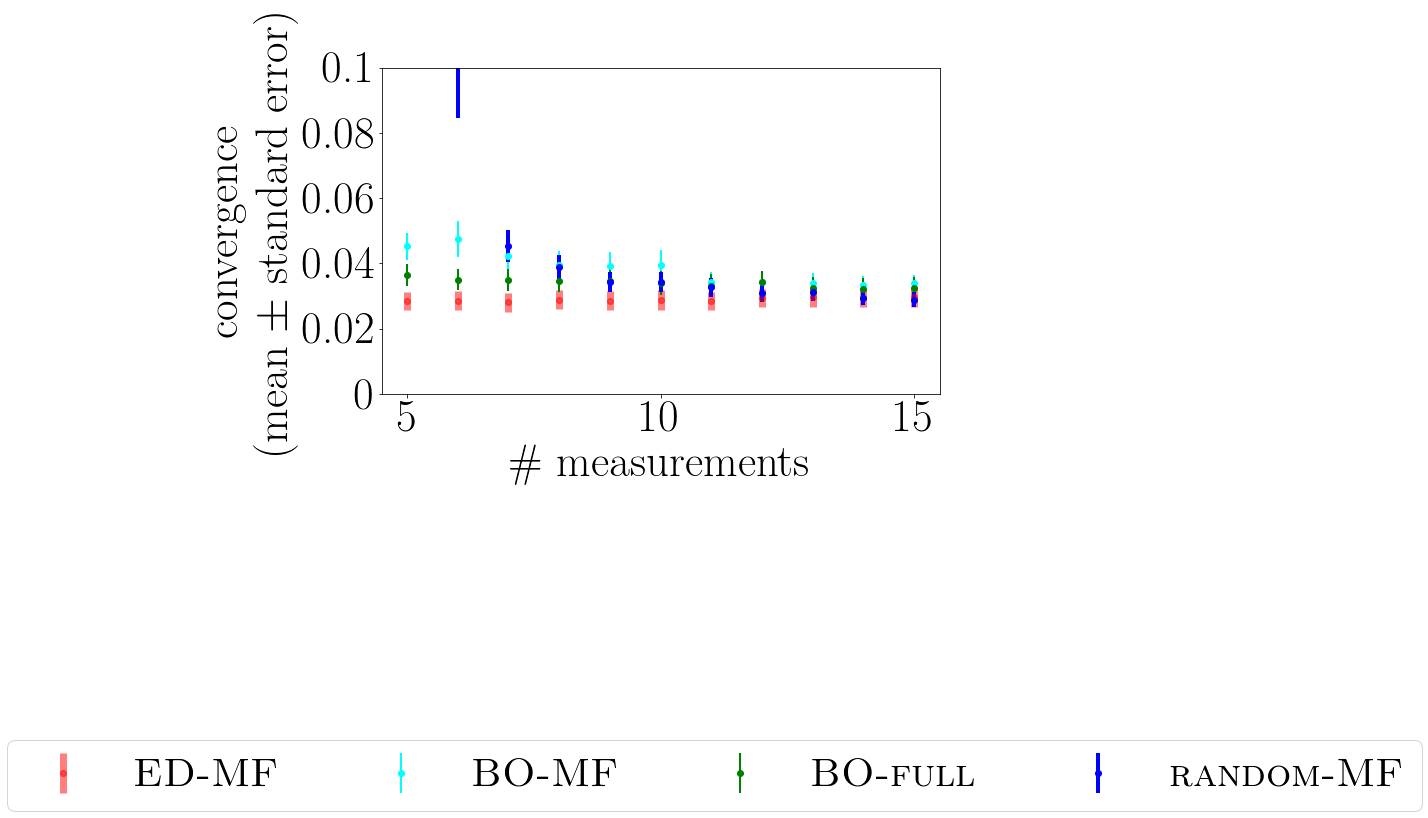

In [30]:
elinewidth = 2
fontsize_axes = 45
legend_marker_size = 40
linewidth = 3

fig, ax = plt.subplots(figsize=(10, 6))
colors = ['red', 'blue', 'cyan', 'purple', 'green', 'orange']

ax.errorbar(n_bo_all, np.mean(dist_all_mean_all_datasets_ed, axis=0), sem(dist_all_mean_all_datasets_ed, axis=0, ddof=0, nan_policy='omit'), 
            color=colors[0], fmt='o', linewidth=linewidth, elinewidth=elinewidth+5, label=r'\textsc{ED-MF}', alpha=0.5)
ax.errorbar(n_bo_all, np.mean(dist_all_mean_all_datasets_gp, axis=0), sem(dist_all_mean_all_datasets_gp, axis=0, ddof=0, nan_policy='omit'), 
            color=colors[2], fmt='o', linewidth=linewidth, elinewidth=elinewidth, label=r'\textsc{BO-MF}')
ax.errorbar(n_bo_all, np.mean(dist_all_mean_all_datasets_gp_full, axis=0), sem(dist_all_mean_all_datasets_gp_full, axis=0, ddof=0, nan_policy='omit'), 
            color=colors[4], fmt='o', linewidth=linewidth, elinewidth=elinewidth, label=r'\textsc{BO-full}')
ax.errorbar(n_bo_all, np.mean(dist_all_mean_all_datasets_random, axis=0), sem(dist_all_mean_all_datasets_random, axis=0, ddof=0, nan_policy='omit'), 
            color=colors[1], fmt='o', linewidth=linewidth, elinewidth=elinewidth+2, label=r'\textsc{random-MF}')
# ax.errorbar(observation_ratios, prediction_errors_mean, prediction_errors_std, color=colors[0], drawstyle='steps-post', linewidth=linewidth, elinewidth=elinewidth)

ax.set_xlabel('\# measurements', fontsize=fontsize_axes)
ax.set_ylabel('convergence \n \\ (mean $\pm$ standard error)', fontsize=fontsize_axes)


vals_xtick = [5, 10, 15]
ax.set_xticks(vals_xtick)
ax.set_xticklabels(vals_xtick, fontsize=fontsize_axes)


# vals_ytick = [0, 0.05, 0.1, 0.15]
vals_ytick = [0, 0.02, 0.04, 0.06, 0.08, 0.1]
ax.set_yticks(vals_ytick)
ax.set_yticklabels(vals_ytick, fontsize=fontsize_axes)

plt.yticks(fontsize=fontsize_axes)
plt.ylim(bottom=0, top=0.1)


fig_path = 'figs'
if not os.path.exists(fig_path):
    os.makedirs(fig_path)
legend = plt.legend(loc='lower', bbox_to_anchor=(1.9, -1), fontsize=legend_marker_size, ncol=4)
def export_legend(legend, expand=[-5,-5,5,5]):
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent()
    bbox = bbox.from_extents(*(bbox.extents + np.array(expand)))
    bbox = bbox.transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(os.path.join(fig_path, "meta_test_legend.pdf"), bbox_inches=bbox)
    
export_legend(legend)

plt.savefig(os.path.join(fig_path, "meta_test_Setting_II_convergence_se.pdf"), bbox_inches='tight')

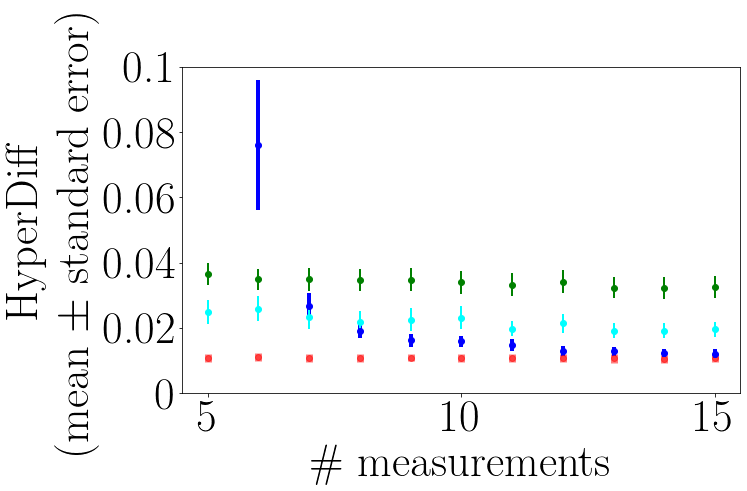

In [31]:
#with errorbar
elinewidth = 2
fontsize_axes = 45
legend_marker_size = 40
linewidth = 3

fig, ax = plt.subplots(figsize=(10, 6))
colors = ['red', 'blue', 'cyan', 'purple', 'green', 'orange']

ax.errorbar(n_bo_all, np.mean(hd_all_mean_all_datasets_ed, axis=0), sem(hd_all_mean_all_datasets_ed, axis=0, ddof=0, nan_policy='omit'), 
            color=colors[0], fmt='o', linewidth=linewidth, elinewidth=elinewidth+5, label='experiment design', alpha=0.5)
ax.errorbar(n_bo_all, np.mean(hd_all_mean_all_datasets_random, axis=0), sem(hd_all_mean_all_datasets_random, axis=0, ddof=0, nan_policy='omit'), 
            color=colors[1], fmt='o', linewidth=linewidth, elinewidth=elinewidth+2, label='random selection')
ax.errorbar(n_bo_all, np.mean(hd_all_mean_all_datasets_gp, axis=0), sem(hd_all_mean_all_datasets_gp, axis=0, ddof=0, nan_policy='omit'), 
            color=colors[2], fmt='o', linewidth=linewidth, elinewidth=elinewidth, label='Bayesian optimization')
ax.errorbar(n_bo_all, np.mean(dist_all_mean_all_datasets_gp_full, axis=0), sem(dist_all_mean_all_datasets_gp_full, axis=0, ddof=0, nan_policy='omit'), 
            color=colors[4], fmt='o', linewidth=linewidth, elinewidth=elinewidth, label='Bayesian optimization (full)')
# ax.errorbar(observation_ratios, prediction_errors_mean, prediction_errors_std, color=colors[0], drawstyle='steps-post', linewidth=linewidth, elinewidth=elinewidth)

ax.set_xlabel('\# measurements', fontsize=fontsize_axes)
ax.set_ylabel('HyperDiff \n \\ (mean $\pm$ standard error)', fontsize=fontsize_axes)


vals_xtick = [5, 10, 15]
ax.set_xticks(vals_xtick)
ax.set_xticklabels(vals_xtick, fontsize=fontsize_axes)

vals_ytick = [0, 0.02, 0.04, 0.06, 0.08, 0.1]
ax.set_yticks(vals_ytick)
ax.set_yticklabels(vals_ytick, fontsize=fontsize_axes)

plt.yticks(fontsize=fontsize_axes)
# plt.ylim(bottom=0, top=0.15)
plt.ylim(bottom=0, top=0.1)

fig_path = 'figs'
if not os.path.exists(fig_path):
    os.makedirs(fig_path)

plt.savefig(os.path.join(fig_path, "meta_test_Setting_II_hd_se.pdf"), bbox_inches='tight')

# ranking of selected best

In [32]:
best_error_baseline = np.full(error_matrix_part.shape[0], np.nan)

# dists_all_std_all_datasets = 
for meta_training_idx, meta_test_idx in loo.split(error_matrix_part):
    meta_test_idx = meta_test_idx[0]
    error_matrix_part_train = error_matrix_part[meta_training_idx]
    error_matrix_part_test = error_matrix_part[meta_test_idx]
    memory_matrix_part_train = memory_matrix_part[meta_training_idx]
    memory_matrix_part_test = memory_matrix_part[meta_test_idx]

    memory_matrix_part_train_flattened = memory_matrix_part_train.flatten()
    error_matrix_part_train_flattened = error_matrix_part_train.flatten()
    memory_matrix_part_test_flattened = memory_matrix_part_test.flatten()
    error_matrix_part_test_flattened = error_matrix_part_test.flatten()
    
#     memory_cap = np.inf
    memory_cap = np.median(memory_matrix_part.flatten())
    
    is_valid_test = np.where(memory_matrix_part_test <= memory_cap)[0]

    error_matrix_part_test_trunc = error_matrix_part_test[is_valid_test]
    memory_matrix_part_test_trunc = memory_matrix_part_test[is_valid_test]
    
    indices_below_cap = np.where(memory_matrix_part_test_trunc <= memory_cap)[0]
    memory_part_test_trunc_under_cap = memory_matrix_part_test_trunc[indices_below_cap]
    np.random.seed(meta_test_idx)
    idx_max_memory_below_cap = np.random.choice(np.array(np.argwhere(memory_part_test_trunc_under_cap == np.amax(memory_part_test_trunc_under_cap)).flatten().tolist()), 1)[0]
    
    best_error_baseline[meta_test_idx] = ((error_matrix_part_test[is_valid_test])[indices_below_cap])[idx_max_memory_below_cap]

In [37]:
ed_ranking = np.full((error_matrix_part.shape[0], len(n_bo_all)), np.nan)
random_ranking = np.full((error_matrix_part.shape[0], len(n_bo_all)), np.nan)
gp_ranking = np.full((error_matrix_part.shape[0], len(n_bo_all)), np.nan)
gp_full_ranking = np.full((error_matrix_part.shape[0], len(n_bo_all)), np.nan)
baseline_ranking = np.full((error_matrix_part.shape[0], len(n_bo_all)), np.nan)

for meta_test_idx in range(error_matrix_part.shape[0]):
    for idx_n_bo, n_bo in enumerate(n_bo_all):
        val_ed = best_error_on_frontier_all_datasets_ed[meta_test_idx, idx_n_bo]
        val_random = best_error_on_frontier_all_datasets_random[meta_test_idx, idx_n_bo]
        val_gp = best_error_on_frontier_all_datasets_gp[meta_test_idx, idx_n_bo]
        val_gp_full = best_error_on_frontier_all_datasets_gp_full[meta_test_idx, idx_n_bo]
        val_baseline = best_error_baseline[meta_test_idx]
        
        tmp0, tmp1, tmp2, tmp3, tmp4 = sp.stats.rankdata(np.array([val_ed, val_random, val_gp, val_gp_full, val_baseline]), method='min')
        ed_ranking[meta_test_idx, idx_n_bo] = tmp0
        random_ranking[meta_test_idx, idx_n_bo] = tmp1
        gp_ranking[meta_test_idx, idx_n_bo] = tmp2
        gp_full_ranking[meta_test_idx, idx_n_bo] = tmp3
        baseline_ranking[meta_test_idx, idx_n_bo] = tmp4
#         tmp0, tmp1, tmp2, tmp4 = sp.stats.rankdata(np.array([val_ed, val_random, val_gp, val_baseline]), method='min')
#         ed_ranking[meta_test_idx, idx_n_bo] = tmp0
#         random_ranking[meta_test_idx, idx_n_bo] = tmp1
#         gp_ranking[meta_test_idx, idx_n_bo] = tmp2
#         baseline_ranking[meta_test_idx, idx_n_bo] = tmp4

# aggregate error ranking
ed_ranking_mean = np.nanmean(ed_ranking, axis=0)
ed_ranking_ste = sem(ed_ranking, axis=0, ddof=0, nan_policy='omit')
random_ranking_mean = np.nanmean(random_ranking, axis=0)
random_ranking_ste = sem(random_ranking, axis=0, ddof=0, nan_policy='omit')
gp_ranking_mean = np.nanmean(gp_ranking, axis=0)
gp_ranking_ste = sem(gp_ranking, axis=0, ddof=0, nan_policy='omit')

gp_full_ranking_mean = np.nanmean(gp_full_ranking, axis=0)
gp_full_ranking_ste = sem(gp_full_ranking, axis=0, ddof=0, nan_policy='omit')

baseline_ranking_mean = np.nanmean(baseline_ranking, axis=0)
baseline_ranking_ste = sem(baseline_ranking, axis=0, ddof=0, nan_policy='omit')

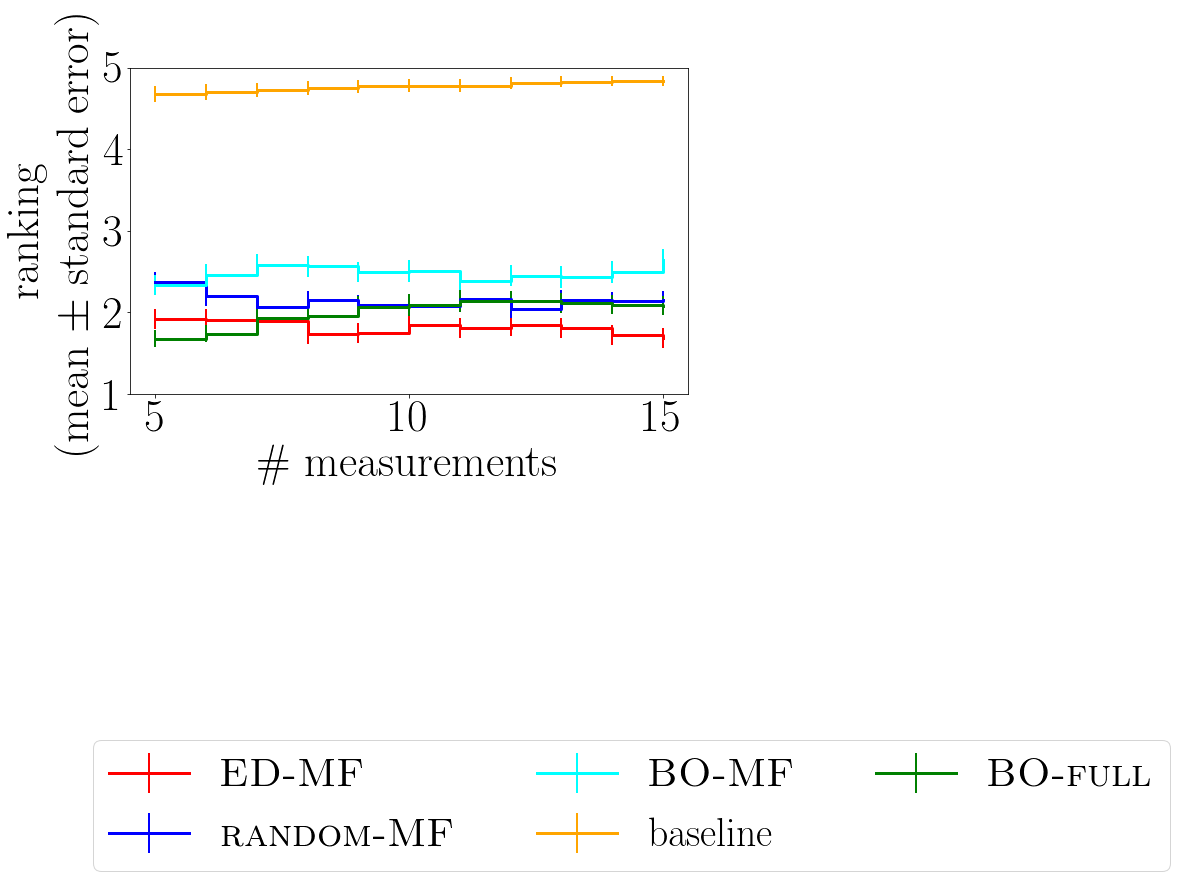

In [38]:
#with errorbar
elinewidth = 2
fontsize_axes = 45
legend_marker_size = 40
linewidth = 3

fig, ax = plt.subplots(figsize=(10, 6))
colors = ['red', 'blue', 'cyan', 'purple', 'green', 'orange']
ax.errorbar(n_bo_all, ed_ranking_mean, ed_ranking_ste, color=colors[0], drawstyle='steps-post', linewidth=linewidth, elinewidth=elinewidth, label=r'\textsc{ED-MF}')
ax.errorbar(n_bo_all, random_ranking_mean, random_ranking_ste, color=colors[1], drawstyle='steps-post', linewidth=linewidth, alpha=1, elinewidth=elinewidth, label=r'\textsc{random-MF}')
ax.errorbar(n_bo_all, gp_ranking_mean, gp_ranking_ste, color=colors[2], drawstyle='steps-post', linewidth=linewidth, elinewidth=elinewidth, label=r'\textsc{BO-MF}')
ax.errorbar(n_bo_all, baseline_ranking_mean, baseline_ranking_ste, color=colors[5], drawstyle='steps-post', linewidth=linewidth, elinewidth=elinewidth, label=r'baseline')
ax.errorbar(n_bo_all, gp_full_ranking_mean, gp_full_ranking_ste, color=colors[4], drawstyle='steps-post', linewidth=linewidth, elinewidth=elinewidth, label=r'\textsc{BO-full}')

ax.set_xlabel('\# measurements', fontsize=fontsize_axes)
ax.set_ylabel('ranking \n (mean $\pm$ standard error)', fontsize=fontsize_axes)


vals_xtick = [5, 10, 15]
ax.set_xticks(vals_xtick)
ax.set_xticklabels(vals_xtick, fontsize=fontsize_axes)

# vals_ytick = [0, 0.05, 0.1, 0.15]
vals_ytick = [1, 2, 3, 4, 5]
ax.set_yticks(vals_ytick)
ax.set_yticklabels(vals_ytick, fontsize=fontsize_axes)
# # plt.ylim(bottom=0, top=0.15)
plt.ylim(bottom=1, top=5)

legend = plt.legend(loc='lower', bbox_to_anchor=(1.9, -1), fontsize=legend_marker_size, ncol=3)

def export_legend(legend, expand=[-5,-5,5,5]):
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent()
    bbox = bbox.from_extents(*(bbox.extents + np.array(expand)))
    bbox = bbox.transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(os.path.join(fig_path, 'meta_test_ranking_legend.pdf'), bbox_inches=bbox)
    
export_legend(legend)

fig_path = 'figs'
if not os.path.exists(fig_path):
    os.makedirs(fig_path)

plt.savefig(os.path.join(fig_path, "meta_test_Setting_II_ranking_se.pdf"), bbox_inches='tight')